# Hyperparameter Tuning

## Setup

In [11]:
# import depedencies
import pandas as pd 
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt 
import itertools

In [2]:
# load & clean data 
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Train.csv', header=0)
train_clean = train[train["tweet"].map(len) <= 280].drop_duplicates() # drop posts longer than 280 characters & drop duplicates
X_train, y_train = train_clean["tweet"], train_clean["label"]


val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Val.csv', header=0)
val_clean = val[val["tweet"].map(len) <= 280].drop_duplicates()  # drop posts longer than 280 characters & drop duplicates
X_val, y_val = val_clean["tweet"], val_clean["label"]

In [ ]:
# Compare df size before vs. after 
print("Train set\n---------", f"\nbefore: {train.shape[0]}", f"\nafter: {X_train.shape[0]}", f"\nWe lost {train.shape[0]-X_train.shape[0]} tweets or {round(100*(train.shape[0]-X_train.shape[0])/train.shape[0],1)}% of observations\n")
print("Validation set\n--------------", f"\nbefore:", val.shape[0],"\nafter:", X_val.shape[0], f"\nWe lost {val.shape[0]-X_val.shape[0]} tweets or {round(100*(val.shape[0]-X_val.shape[0])/val.shape[0],1)}% of observations\n")

# Pre-Processing

In [3]:
# Import label encoder
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'label'.
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
#y_test = label_encoder.fit_transform(y_test)

In [5]:
import nltk 
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

# create stop word list
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stoplist = list(STOP_WORDS)

# create CleanText() function
def CleanText(string):
    text = string.lower() # lowercase
    #text = text.split() #  splits into a list of words
    #text = " ".join(text) # joins the list of words
    # .split() + .join() cancel each other out -- consider removing?
    text = re.sub(r"http(\S)+",' ',text) # remove URLs   
    text = re.sub(r"www(\S)+",' ',text) # remove URLs
    text = re.sub(r"&",' and ',text) # replace & with ' and '
    text = text.replace('&amp',' ') # replace &amp with ' '
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text) # remove non-alphanumeric characters
    text = text.split() # splits into a list of words
    text = [w for w in text if not w in stoplist] # remove stop words
    text = [lemmatizer.lemmatize(w) for w in text] # lemmatization
    text = " ".join(text) # joins the list of words
    return text

# apply CleanText() function to all tweets 
X_train = X_train.map(lambda x: CleanText(x))
X_val = X_val.map(lambda x: CleanText(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Feature Extraction

## Bag of Words

In [7]:
# count vectorizer
cv = CountVectorizer(ngram_range=(1, 2)) # count term frequency

# fit and transform train data to count vectorizer
cv.fit(X_train.values)
cv_train = cv.transform(X_train.values)

# fit and transform validation data to counter vectorizer
cv_val = cv.transform(X_val.values)

## TF-IDF

In [8]:
# TF-IDF
tfidf = TfidfTransformer()

# fit the CountVector to TF-IDF transformer
tfidf.fit(cv_train)
tfidf_train = tfidf.transform(cv_train)

# do the same for the validation set
tfidf.fit(cv_val)
tfidf_val = tfidf.transform(cv_val)

## Logistic Regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# create logistic regression object
log_reg = LogisticRegression()

# create list of parameters
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [100, 1000]
}

grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1')

grid.fit(tfidf_train,y_train)
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
#print(f"Standard deviation of CV score: {std_test_score: .6f}")

In [12]:
# create logistic regression object
log_reg = LogisticRegression(max_iter=1000, penalty='none', solver='saga')

# create pipeline
pipeline = Pipeline([
        ('count', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', log_reg) # classifier
    ])

# train model
fit = pipeline.fit(X_train,y_train)
print('Logistic Regression')
print('val:')

# make predictions
pred = pipeline.predict(X_val) 

Logistic Regression
val:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [13]:
# define plot_confusion_matrix() function to display results
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

In [14]:
# define print_metrics() function to print results
def print_metrics(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

[[895  53]
 [ 66 859]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       948
           1       0.94      0.93      0.94       925

    accuracy                           0.94      1873
   macro avg       0.94      0.94      0.94      1873
weighted avg       0.94      0.94      0.94      1873

Accuracy :  0.9364655632674853
Precison :  0.9365727572443259
Recall :  0.9364655632674853
F1 :  0.9364740421760592


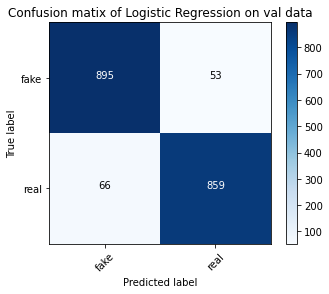

In [15]:
# display results
print_metrics(pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Logistic Regression on val data')